In [1]:
import pandas as pd
import numpy as np
import datetime
import plotly.express as px
from pmdarima.arima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import acovf,acf,pacf
from sklearn.metrics import mean_squared_error

In [2]:
import torch
# import pytorch_lightning as pl
import lightning.pytorch as pl
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
# from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
import pytorch_forecasting as ptf
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet, DeepAR
from pytorch_forecasting.metrics.distributions import MultivariateNormalDistributionLoss
from pytorch_forecasting.metrics.point import RMSE

/home/harsh242/mambaforge/envs/rossmann2/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [3]:
store_df = pd.read_csv('data/store.csv')
test_df = pd.read_csv('data/test.csv')
train_df = pd.read_csv('data/train.csv')
sample_submission_df = pd.read_csv('data/sample_submission.csv')

/tmp/ipykernel_15100/3598239639.py:3: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv('data/train.csv')


In [4]:
train_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1


In [5]:
store_df

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


## Data preprocessing

#### Checking any problems with the data

In [6]:
train_df.StateHoliday.unique()

array(['0', 'a', 'b', 'c', 0], dtype=object)

The value 0 occurs in two data types

In [7]:
train_df.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [8]:
def one_hot_encode(df, column_name):
    one_hot_df = pd.get_dummies(df[column_name], prefix=column_name+"_", drop_first=False, dtype=int)
    new_cols = df.columns.drop(column_name)
    new_df = pd.concat([df[new_cols], one_hot_df], axis=1)
    return new_df

def preprocess_data(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df.loc[df['StateHoliday'] == 0, 'StateHoliday'] = '0'
    # df = one_hot_encode(df, 'StateHoliday')
    df = df.sort_values(by=['Store', 'Date']).reset_index(drop=True)
    # df = df.iloc[::-1].reset_index(drop=True)
    
    return df
    

In [9]:
train_df = preprocess_data(train_df)
train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,2,2013-01-01,0,0,0,0,a,1
1,1,3,2013-01-02,5530,668,1,0,0,1
2,1,4,2013-01-03,4327,578,1,0,0,1
3,1,5,2013-01-04,4486,619,1,0,0,1
4,1,6,2013-01-05,4997,635,1,0,0,1


In [10]:
test_df = preprocess_data(test_df)
test_df.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,40233,1,6,2015-08-01,1.0,0,0,1
1,39377,1,7,2015-08-02,0.0,0,0,1
2,38521,1,1,2015-08-03,1.0,1,0,1
3,37665,1,2,2015-08-04,1.0,1,0,1
4,36809,1,3,2015-08-05,1.0,1,0,1


## Exploring the data

In [11]:
# corr_df = train_df[list(train_df.columns[1:])].corr()
# corr_df

In [12]:
# fig = px.imshow(corr_df)
# fig.show("png")

Customers and Open columns are strongly correlated with Sales

#### Looking at the data of a random store

In [13]:
df_store_x = train_df[train_df['Store'] == 1011]
df_store_x

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
921243,1011,2,2013-01-01,0,0,0,0,a,1
921244,1011,3,2013-01-02,7049,900,1,0,0,1
921245,1011,4,2013-01-03,6377,802,1,0,0,1
921246,1011,5,2013-01-04,5981,793,1,0,0,1
921247,1011,6,2013-01-05,7963,1043,1,0,0,0
...,...,...,...,...,...,...,...,...,...
922180,1011,1,2015-07-27,10066,902,1,1,0,1
922181,1011,2,2015-07-28,8673,834,1,1,0,1
922182,1011,3,2015-07-29,7755,732,1,1,0,1
922183,1011,4,2015-07-30,9227,877,1,1,0,1


In [14]:
# store_corr_df = train_df[list(df_store_x.columns[1:])].corr()
# store_corr_df

In [15]:
# fig = px.imshow(store_corr_df)
# fig.show("png")

Same correlation is observed for this particular store

## Exploring LSTM model.

In [16]:
df_store_x.loc[:, "TimeIndex"] = range(0, len(df_store_x))

/tmp/ipykernel_15100/359616140.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_store_x.loc[:, "TimeIndex"] = range(0, len(df_store_x))


In [17]:
# df.astype({'col1': 'int32'}).dtypes
df_store_x = df_store_x.astype({'Store': 'str', 'DayOfWeek': 'str', 'Open': 'str', 'Promo': 'str', 'StateHoliday': 'str', 
                                'SchoolHoliday': 'str', 'Sales': 'float64'})

In [18]:
df_store_x.dtypes

Store                    object
DayOfWeek                object
Date             datetime64[ns]
Sales                   float64
Customers                 int64
Open                     object
Promo                    object
StateHoliday             object
SchoolHoliday            object
TimeIndex                 int64
dtype: object

In [19]:
df_store_x.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,TimeIndex
921243,1011,2,2013-01-01,0.0,0,0,0,a,1,0
921244,1011,3,2013-01-02,7049.0,900,1,0,0,1,1
921245,1011,4,2013-01-03,6377.0,802,1,0,0,1,2
921246,1011,5,2013-01-04,5981.0,793,1,0,0,1,3
921247,1011,6,2013-01-05,7963.0,1043,1,0,0,0,4


In [20]:
df_store_x.tail()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,TimeIndex
922180,1011,1,2015-07-27,10066.0,902,1,1,0,1,937
922181,1011,2,2015-07-28,8673.0,834,1,1,0,1,938
922182,1011,3,2015-07-29,7755.0,732,1,1,0,1,939
922183,1011,4,2015-07-30,9227.0,877,1,1,0,1,940
922184,1011,5,2015-07-31,10134.0,1021,1,1,0,1,941


In [21]:
# df_store_x.tail(60)

In [22]:
# train_df.StateHoliday.unique()
df_store_x.Open.unique()

array(['0', '1'], dtype=object)

In [23]:
df_store_x["TimeIndex"].max() - 50

891

In [24]:
842/2

421.0

In [25]:
(421+50)*2

942

In [26]:
max_encoder_length = 421
max_prediction_length = 50
training_cutoff = df_store_x["TimeIndex"].max() - max_prediction_length

training = TimeSeriesDataSet(
    df_store_x[lambda x: x.TimeIndex <= training_cutoff],
    time_idx="TimeIndex",
    target="Sales",
    group_ids=["Store"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    time_varying_unknown_reals=["Sales"],
    static_categoricals=["Store"],
    # time_varying_known_reals=["DayOfWeek"],
    time_varying_known_categoricals=["DayOfWeek", "Open", "Promo", "StateHoliday"],
)

validation = TimeSeriesDataSet.from_dataset(training, df_store_x, min_prediction_idx=training_cutoff + 1)

In [27]:
train_loader = training.to_dataloader(train=True, batch_size=50, batch_sampler="synchronized")
test_loader = validation.to_dataloader(train=False, batch_size=50, batch_sampler="synchronized")

/home/harsh242/mambaforge/envs/rossmann2/lib/python3.10/site-packages/pytorch_forecasting/data/samplers.py:86: UserWarning: Less than 50 samples available for 422 prediction times. Use batch size smaller than 50. First 10 prediction times with small batch sizes: [422, 423, 424, 425, 426, 427, 428, 429, 430, 431]
  warnings.warn(


In [28]:
print("train_loader: ", len(train_loader))
print("train_loader: ", len(train_loader.dataset))

train_loader:  422
train_loader:  422


In [29]:
print("test_loader: ", len(test_loader))
print("test_loader: ", len(test_loader.dataset))

test_loader:  1
test_loader:  1


In [30]:
# val_dataset

# Assuming val_dataset is a DataLoader object
print("test_loader: ", len(test_loader))
print("test_loader: ", len(test_loader.dataset))
for i, data in enumerate(test_loader):
    if i == 0:
        # print("data: ", data)
        print("data.keys(): ", data[0].keys())
        for key in data[0].keys():
            print(key, data[0][key].shape)
        break
    # print("data: ", data)
    # features, label = data

    # Break after the first batch for demonstration purposes
    # if i == 0:
    #     break

test_loader:  1
test_loader:  1
data.keys():  dict_keys(['encoder_cat', 'encoder_cont', 'encoder_target', 'encoder_lengths', 'decoder_cat', 'decoder_cont', 'decoder_target', 'decoder_lengths', 'decoder_time_idx', 'groups', 'target_scale'])
encoder_cat torch.Size([1, 421, 5])
encoder_cont torch.Size([1, 421, 1])
encoder_target torch.Size([1, 421])
encoder_lengths torch.Size([1])
decoder_cat torch.Size([1, 50, 5])
decoder_cont torch.Size([1, 50, 1])
decoder_target torch.Size([1, 50])
decoder_lengths torch.Size([1])
decoder_time_idx torch.Size([1, 50])
groups torch.Size([1, 1])
target_scale torch.Size([1, 2])


In [31]:
# calculate baseline absolute error
baseline_predictions = Baseline().predict(test_loader, trainer_kwargs=dict(accelerator="auto"), return_y=True)
RMSE()(baseline_predictions.output, baseline_predictions.y)

/home/harsh242/mambaforge/envs/rossmann2/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/harsh242/mambaforge/envs/rossmann2/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, rea

tensor(2916.5068, device='cuda:0')

In [32]:
pl.seed_everything(42)

trainer = pl.Trainer(accelerator="auto", gradient_clip_val=1e-1)
net = DeepAR.from_dataset(
    training,
    learning_rate=3e-2,
    hidden_size=30,
    rnn_layers=2,
    loss=MultivariateNormalDistributionLoss(rank=2),
    optimizer="Adam",
)

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/harsh242/mambaforge/envs/rossmann2/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/harsh242/mambaforge/envs/rossmann2/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


/home/harsh242/mambaforge/envs/rossmann2/lib/python3.10/site-packages/lightning/pytorch/loops/utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/harsh242/mambaforge/envs/rossmann2/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
/home/harsh242/mambaforge/envs/rossmann2/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.08912509381337459
Restoring states from the checkpoint path at /home/harsh242/pc_data/academics/rossmann-sales-forecast/.lr_find_5e33a13c-c717-4188-a8e4-1631da5d7b76.ckpt
Restored all states from the checkpoint at /home/harsh242/pc_data/academics/rossmann-sales-forecast/.lr_find_5e33a13c-c717-4188-a8e4-1631da5d7b76.ckpt


suggested learning rate: 0.08912509381337459


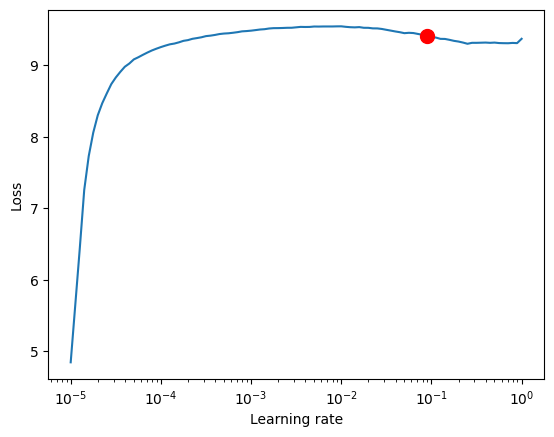

/tmp/ipykernel_15100/2658754104.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [33]:
# find optimal learning rate
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    net,
    train_dataloaders=train_loader,
    val_dataloaders=test_loader,
    min_lr=1e-5,
    max_lr=1e0,
    early_stop_threshold=100,
)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
net.hparams.learning_rate = res.suggestion()

In [34]:
from lightning.pytorch import loggers as pl_loggers
# tensorboard = pl_loggers.TensorBoardLogger('./')

early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
trainer = pl.Trainer(
    max_epochs=30,
    accelerator="auto",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    callbacks=[early_stop_callback],
    limit_train_batches=50,
    enable_checkpointing=True,
    # logger=tensorboard
)


net = DeepAR.from_dataset(
    training,
    learning_rate=0.08912,
    log_interval=10,
    log_val_interval=1,
    hidden_size=30,
    rnn_layers=2,
    optimizer="Adam",
    loss=MultivariateNormalDistributionLoss(rank=2),
)

trainer.fit(
    net,
    train_dataloaders=train_loader,
    val_dataloaders=test_loader,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type                               | Params
------------------------------------------------------------------------------
0 | loss                   | MultivariateNormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList                         | 0     
2 | embeddings             | MultiEmbedding                     | 52    
3 | rnn                    | LSTM                               | 12.7 K
4 | distribution_projector | Linear                             | 124   
------------------------------------------------------------------------------
12.9 K    Trainable params
0         Non-trainable params
12.9 K    Total params
0.052     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [38]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = DeepAR.load_from_checkpoint(best_model_path)

In [39]:
# best_model = net
predictions = best_model.predict(test_loader, trainer_kwargs=dict(accelerator="auto"), return_y=True)
RMSE()(predictions.output, predictions.y)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/harsh242/mambaforge/envs/rossmann2/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


tensor(1230.0452, device='cuda:0')

In [40]:
raw_predictions = net.predict(
    test_loader, mode="raw", return_x=True, n_samples=50, trainer_kwargs=dict(accelerator="auto")
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/harsh242/mambaforge/envs/rossmann2/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


In [41]:
import matplotlib.pyplot as plt

In [51]:
raw_predictions.x.keys()

dict_keys(['encoder_cat', 'encoder_cont', 'encoder_target', 'encoder_lengths', 'decoder_cat', 'decoder_cont', 'decoder_target', 'decoder_lengths', 'decoder_time_idx', 'groups', 'target_scale'])

In [52]:
validation.x_to_index(raw_predictions.x)["Store"]

0    1011
Name: Store, dtype: object

In [ ]:
fig = px.line(forecast_df, x="Date", y=["Sales", "SarimaForecast", "SarimaxForecast"], width=1200, height=380)
fig.show("png")

In [ ]:
forecast_df = df_store_x[['Store', 'Date', 'Sales']].copy()
forecast_df['Forecast'] = np.array(sarima_forecast)
forecast_df.head()

In [57]:
df_store_x.tail()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,TimeIndex
922180,1011,1,2015-07-27,10066.0,902,1,1,0,1,937
922181,1011,2,2015-07-28,8673.0,834,1,1,0,1,938
922182,1011,3,2015-07-29,7755.0,732,1,1,0,1,939
922183,1011,4,2015-07-30,9227.0,877,1,1,0,1,940
922184,1011,5,2015-07-31,10134.0,1021,1,1,0,1,941


In [85]:
y_true = np.array(df_store_x['Sales'][-50:])

In [86]:
y_pred = np.array(raw_predictions.output[0][0][-1].cpu())

In [94]:
# ((y_pred - y_true)**2).sum()/len(y_true)
np.sqrt(((y_pred - y_true)**2).sum()/len(y_true))

3247.210091904491

In [84]:
RMSE()(np.array(raw_predictions.output[0][0][-1].cpu()), np.array(df_store_x['Sales'][-50:]))

TypeError: 'int' object is not callable

In [64]:
raw_predictions.output[0][0][-1].shape

torch.Size([50])

IndexError: index 1 is out of bounds for dimension 0 with size 1

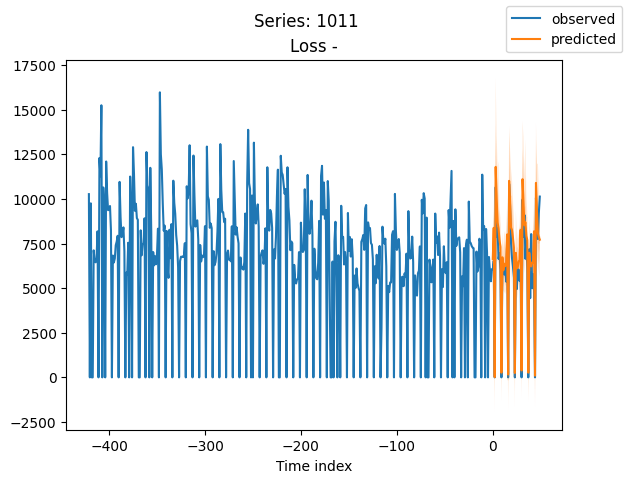

In [53]:
series = validation.x_to_index(raw_predictions.x)["Store"]
for idx in range(20):  # plot 10 examples
    best_model.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True)
    plt.suptitle(f"Series: {series.iloc[idx]}")

In [35]:
# model = DeepAR.from_dataset(
#     dataset,
#     learning_rate=0.01,
#     hidden_size=32,
#     rnn_layers=2,
#     cell_type='LSTM',
#     loss=MultivariateNormalDistributionLoss()
# )

In [36]:
# trainer = pl.Trainer(
#     max_epochs=50,
#     accelerator="auto",
#     enable_model_summary=True,
# )

In [26]:
# trainer = Trainer(
#     max_epochs=50,
#     accelerator="auto",
#     enable_model_summary=True,
# )

In [37]:
# trainer.fit(model, train_dataset, test_dataset)

In [59]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = DeepAR.load_from_checkpoint(best_model_path)

In [60]:
predictions = best_model.predict(val_dataset, trainer_kwargs=dict(accelerator="auto"), return_y=True)
RMSE()(predictions.output, predictions.y)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/harsh242/mambaforge/envs/rossmann/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 50 but got size 22 for tensor number 9 in the list.

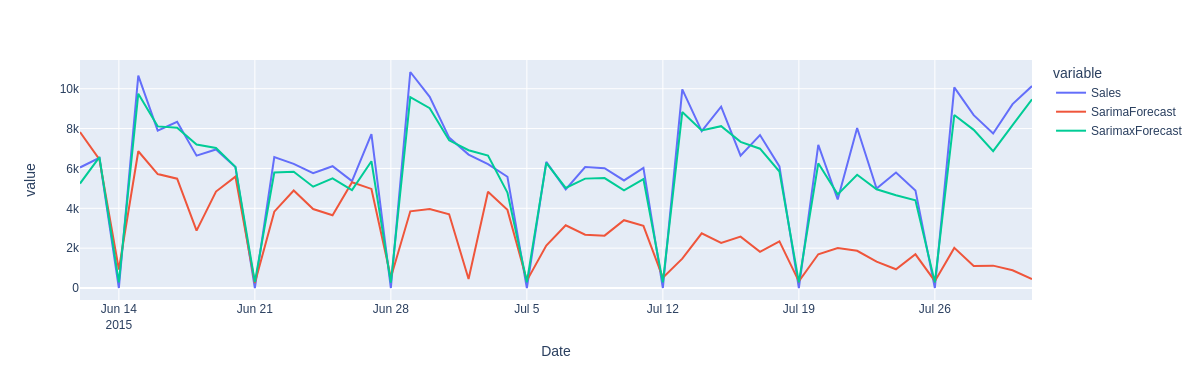

In [44]:
fig = px.line(forecast_df, x="Date", y=["Sales", "SarimaForecast", "SarimaxForecast"], width=1200, height=380)
fig.show("png")

## Conclusion